# Advanced Machine Learning - programming assignment 3

*Due: Friday January 13*

*Grading: 10 points total*

**Please fill in:**
* Niels Teunissen 2305267
* Ian van de Poll 4388232

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2 * z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

The SCM before intervention:

![](a.drawio.png)

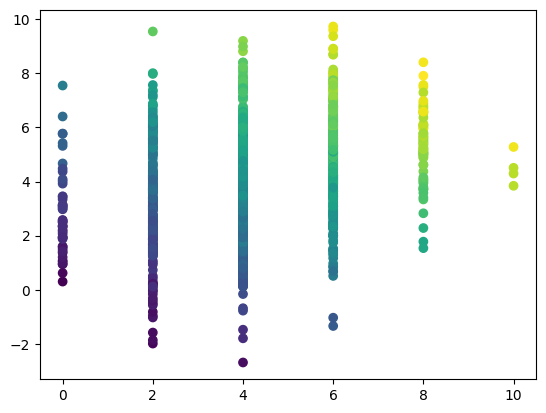

In [2]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

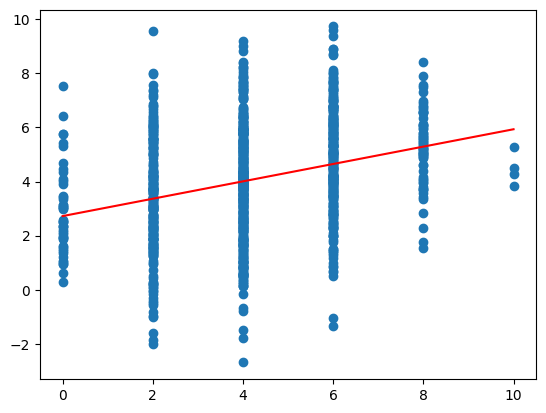

In [3]:
from sklearn.linear_model import LinearRegression

# Your code here

lr = LinearRegression()

lr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

reg_curve_datapoints = np.linspace(0, 10, 1000)

reg_curve_pred = lr.predict(reg_curve_datapoints.reshape(-1, 1))

plt.scatter(x, y)
plt.plot(reg_curve_datapoints, reg_curve_pred, c='red')
plt.show()


Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.



X is a direct cause of Y. Z is direct cause of Y and X. The outcome is directly influenced by the treatment and the genetica information determines the treatment and therefore also the outcome of the treatment.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [4]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Your code here

    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples)

    return x, y, z

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [5]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

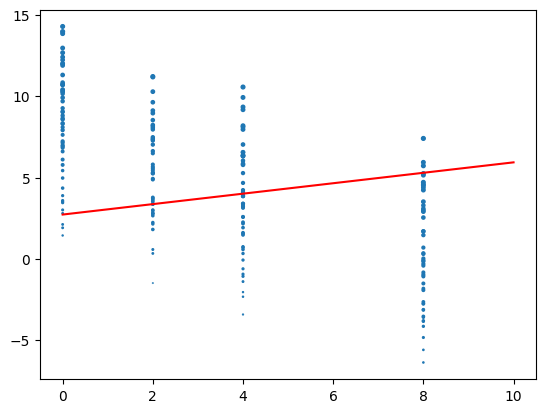

In [6]:
# Your code here

plt.scatter(x_exp, y_exp, z_exp)
plt.plot(reg_curve_datapoints, reg_curve_pred, c='red')
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [7]:
# Your code here

y_exp_pred = lr.predict(x_exp.reshape(-1, 1))

RMSE = np.sqrt(np.sum(np.divide(np.subtract(y_exp_pred.reshape(1, -1)[0], y_exp)**2, num_samples_exp)))

print(RMSE)

5.089011688102947


SCM after intervention:

![](b.png)

You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

The factors of Z and Y are the same between the observational and the experimental distribution, because before the intervention the product decomposition rule is the following: $$P(x,y,z) = P(x|z)*P(y|x,z)*P(z)$$ and after the intervention the product decomposition rule becomes: $$P(x,y,z) = P(x)*P(y|x,z)*P(z)$$ Thus, the factors of Z and Y are the same in the product decomposition rule. However, the values of y and x should change after the intervention.$$P(y|x)$$ needs to stay the same between the two distributions in order to give good predictions on the experimental data. z is of no interest, because it stays the same in the product decomposition rule after the intervention.




**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

X and Y are likely dependent. Moreover, Z and Y are likely dependent. Lastly, X and Z are likely dependent given Y, because they form a collider. X and Z are d-seperated when you condition on the empty set, thus they are independent. Moreover, in the scatterplot below the correlation between X and Y is -0.65 which shows us that X and Y are likely dependent. The correlation between Y and Z is 0.72 therefore they are likely dependent. Lastly, the correlation between X and Z is 0.03, thus there are independent. This is easy to see visually, there is a correlation between both X and Y, Y and Z. There is no correlation between X and Z. It can be tricky to see the correlation between X and Y, however, if you would draw a line through the averages of each blue line there is a clear negative correlation. 



-0.6552984340477992 0.7253644550132512 0.035017703412762564


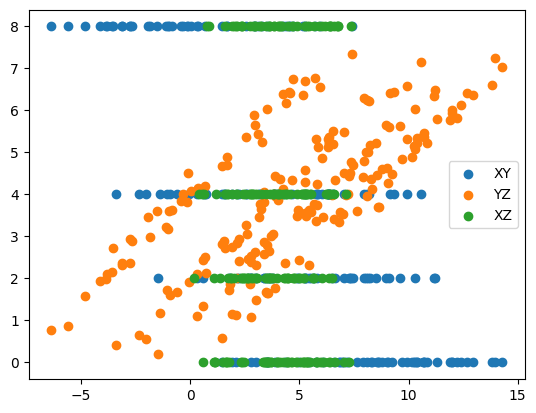

In [69]:
import seaborn as sns
xy = np.corrcoef(x_exp, y_exp)
yz = np.corrcoef(y_exp, z_exp)
xz = np.corrcoef(x_exp, z_exp)
print(xy[0,1],yz[0,1],xz[0,1])
plt.subplots()
plt.scatter(y_exp, x_exp,label="XY")
plt.scatter(y_exp, z_exp,label="YZ")
plt.scatter(z_exp, x_exp,label="XZ")
plt.legend()
plt.show()



**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [21]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(max_iter=500)

reg_logistic.fit(z.reshape(-1, 1), x)
proba = reg_logistic.predict_proba(z.reshape(-1, 1))
propensity = 1/proba

(1000,)


**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

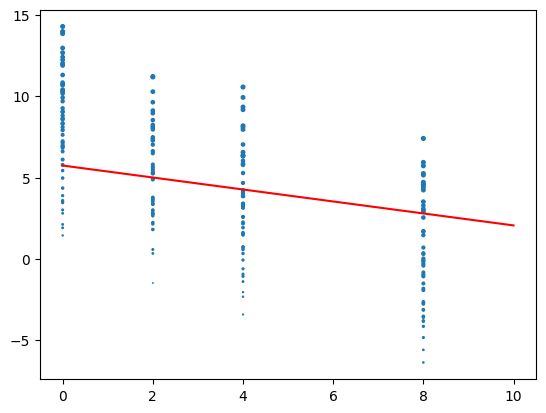

In [24]:
# Your code here
lr_model = linear_model.LinearRegression()

weights = propensity[range(len(propensity)), (x/2).astype(int)]

lr_model.fit(x.reshape(-1, 1), y.reshape(-1, 1), sample_weight=weights)
reg_curve_pred = lr_model.predict(reg_curve_datapoints.reshape(-1,1))

plt.scatter(x_exp, y_exp, z_exp)
plt.plot(reg_curve_datapoints, reg_curve_pred, c='red')
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [25]:
# Your code here

y_exp_pred = lr_model.predict(x_exp.reshape(-1, 1))

RMSE = np.sqrt(np.sum(np.divide(np.subtract(y_exp_pred.reshape(1, -1)[0], y_exp)**2, num_samples_exp)))

print(RMSE)

3.741938016323191


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).